In [79]:
import hashlib
import os
import tarfile
import zipfile 
import requests

#@save
DATA_HUB = dict()
DATA_URL =  'http://d2l-data.s3-accelerate.amazonaws.com/'

In [80]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [81]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [82]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [83]:
DATA_HUB['kaggle_house_train'] = ( #@save
DATA_URL + 'kaggle_house_pred_train.csv',
'585e9cc93e70b39160e7921475f9bcd7d31219ce')

In [84]:
DATA_HUB['kaggle_house_test'] = ( #@save
DATA_URL + 'kaggle_house_pred_test.csv',
'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [85]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [86]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [87]:
print(train_data.iloc[0:4, [1,2,3,-3,-2,-1]])

   MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0          60       RL         65.0       WD        Normal     208500
1          20       RL         80.0       WD        Normal     181500
2          60       RL         68.0       WD        Normal     223500
3          70       RL         60.0       WD       Abnorml     140000


In [88]:
train_data.iloc[:, 1:-1].head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [89]:
test_data.iloc[:,1:].head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [90]:
#removing id

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:,1:]))

In [91]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [92]:
numeric_features[:5]

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'], dtype='object')

In [93]:
def apply_standardisation(x):
    return (x - x.mean())/x.std()

all_features[numeric_features] = all_features[numeric_features].apply(apply_standardisation)
    

In [94]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [95]:
all_features[:5]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal


In [96]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [97]:
all_features.shape

(2919, 331)

In [98]:
n_train = train_data.shape[0]
n_train

1460

In [99]:
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)

In [100]:
loss = nn.MSELoss()

In [101]:
train_features.shape

torch.Size([1460, 331])

In [102]:
in_features = train_features.shape[1]

def get_net(in_features= in_features):
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [124]:
def log_rmse(net, features, labels, loss):
    y_hat= torch.clamp(net(features), 1, float('inf'))
    
    return torch.sqrt(loss(torch.log(y_hat),torch.log(labels))).item()

In [129]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, batch_size, weight_decay, lr):
    train_dataset = torch.utils.data.TensorDataset(*(train_features, train_labels))
    train_iter= torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    
    train_ls = []
    test_ls = []
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        
        train_error = log_rmse(net, train_features, train_labels, loss )
        train_ls.append(train_error)
#         print(f"The rmse loss for the epoch {epoch} is {train_error}")
        
        if(test_labels is not None):
            test_error = log_rmse(net, test_features, test_labels, loss )
            test_ls.append(test_error)
#             print(f"The rmse loss for the epoch {epoch} is {test_error}")
    
    return train_ls, test_ls
        

In [130]:
def get_K_fold(k, i, X, y):
    assert k >1
    
    fold_size = X.shape[0] // k
    
    X_train,y_train = None, None
    
    for j in range(k):
        current_index = slice(j*fold_size, (j+1) * fold_size)
#         print(current_index)
#         break
        X_part, y_part = X[current_index, :], y[current_index, :]
        
        if j == i :
            val_train = X_part
            val_label = y_part
        else :
            if (X_train==None):
                X_train = X_part
                y_train = y_part
            else :
                X_train  = torch.cat([X_train, X_part],0)
                y_train = torch.cat([y_train, y_part],0)

    return X_train, y_train, val_train, val_label

In [139]:
import matplotlib.pyplot as plt

def get_k(k, train_features, train_labels, num_epochs,learning_rate, weights_decay, batch_size):
    train_ls_sum, test_ls_sum = 0,0
    
    for i in range(k):
        data = get_K_fold(k, i, train_features, train_labels)
        net = get_net()
        
        train_ls, test_ls = train(net, *data, num_epochs, batch_size, weight_decay, learning_rate)
        train_ls_sum += train_ls[-1]
        test_ls_sum += test_ls[-1]
        
        if i==0:
            plt.plot(range(1, num_epochs+1), train_ls)
            plt.plot(range(1,num_epochs+1), test_ls)
            plt.grid(True)
            plt.show()
            
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1])} valid loss rmse {float(test_ls[-1])}')
    return train_ls_sum/k, test_ls_sum/k
                                              


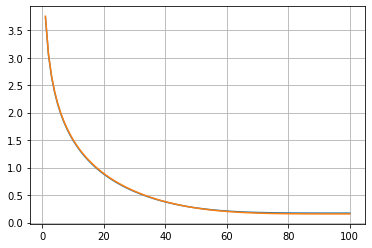

fold 1, train log rmse 0.1708105206489563 valid loss rmse 0.1568821370601654
fold 2, train log rmse 0.16195304691791534 valid loss rmse 0.1905716210603714
fold 3, train log rmse 0.1643325537443161 valid loss rmse 0.16901011765003204
fold 4, train log rmse 0.16808229684829712 valid loss rmse 0.15459726750850677
fold 5, train log rmse 0.16297562420368195 valid loss rmse 0.183088019490242
Avg train log rmse: 0.16563080847263337 Avg test log rmse: 0.17082983255386353


In [140]:
k, num_epochs, lr, weight_decay, batch_size = 5,100,5,0,64

train_l, test_l = get_k(k, train_features, train_labels, num_epochs,lr, weight_decay, batch_size)
print(f'Avg train log rmse: {float(train_l)} Avg test log rmse: {float(test_l)}')

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    #train(net, *data, num_epochs, batch_size, weight_decay, learning_rate)
    train_ls, _ = train(net, train_features, train_features, test_data, test_features, num_epochs, lr, )